<a href="https://colab.research.google.com/github/butler-julie/DataScienceForPhysicists2025/blob/main/10_DataScienceSoftMatter/complete_Softness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Science for Soft Matter

In [1]:
import gdown #download from google drive
import pickle


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


import sklearn.preprocessing as prep
import sklearn.pipeline as pipeline
import sklearn.model_selection as modsel
import sklearn.svm as svm

Soft matter systems are ones where the interaction energies are comparable to the thermal energy. As a result, these systems have complex structures and dynamics. They are often not ordered, and it can be challenging to infer how their structure relates to their properties and dynamics.

A variety of machine learning approaches have been used to study soft matter systems. Some work uses unsupervised methods to try to detect hidden ordering in complex states. Some work uses ML to try to learn the interaction potentials between particles from complex dynamics.

In this brief workshop, I'm going to guide you through one example of one particular approach. We take a system where the connection between the structure and the dynamics isn't obvious: in this case, a molecular dynamics simulation of a "supercooled liquid", or a "glass forming liquid".

Unlike say, water, which crystallizes at low enough temperature $T$, these liquids show no obvious change in their structure as $T$ decreases. Despite this, they show dramatic behaviors in their *dynamics* as $T$ is decreased. For example, we can look at a characteritic relaxation time $\tau_\alpha$ as a function of $1/T$, and we can see the dynamics slowing down dramatically:

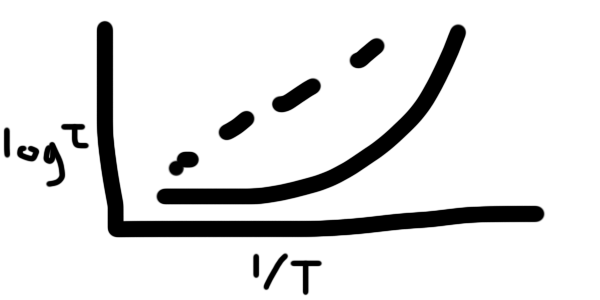

In an experiment, this dramatic slowdown looks like forming a solid "glass", as the relaxation time gets too slow to see any motion. From our perspective, the fact that is especially dramatic is that the curve isn't straight.

A straight line on this plot would correspond to the Arrhenius law:

$$ \tau \propto \exp(\Delta E /T)$$,

indicating that relaxation is governed by a single energy barrier $\Delta E$. So the fact that the curve isn't straight indicates that, even though it's hard to see any difference in the structure as a function of $T$, there is some characteristic energy barrier which is changing as a function of $T$. So we'd like to discover the structural origin of this change in $\Delta E$.


We'll be trying to reproduce some of the results of a paper that made substantial progress in this direction using machine learning, https://doi.org/10.1038/nphys3644. This same approach has been applied in a variety of systems, from experimental granular systems to simulations of models of densely packed biological cells.

The spirit of the approach is that, if there are structural features which are responsible for changes in energy barriers on cooling, they should *also* be responsible for heterogeneity in the dynamics at *fixed* temperature $T$. So we will identify examples of "rearranging" (moving) particles in a simulation,  and ask a machine learning model to identify local structures which are predictive of rearrangement. We will then hopefully learn something about structural features responsible for determining the energy barrier to rearrangement.

In particular, we construct a list of local structural variables $X_{i, \alpha}$, $\alpha=1,\dots 166$, describing the local structure around particle $i$. We will then use the SVM algorithm to train a *linear* model,

$$S_i = w_0 + \sum_\alpha w_\alpha X_{i, \alpha},$$

minimizing a loss function that makes $S_i$ correlate with whether a particle is rearranging or not. We will then study the properties of the "softness" $S$.

The main result of the paper we are trying to reproduce is a simple physical one: that the result of this procedure is a variable $S$ which behaves like a "local energy barrier to rearrangement"

The structural variables $X_{i,\alpha}$ we will use are computed from the positions of the particles surrounding particle $i$. Our simulations contain two "types" of particles, "A" and "B".  The first 50 variables represent the density of A-type neighbors:

$$G_{A,\alpha}(i) = \sum_{j \in A} \exp(-(r_{ij} - \mu_\alpha)^2/2 \sigma^2),$$

and the next 50 are the same for B-type neighbors.

The final 66 structural variables are various "angular" functions which represent something about the angles between triplets of particles, as well as distances.

I've computed these structural variables on various subsets of particles in an MD simulation for you, and we'll load that data and use it to reproduce the paper.

To identify rearranging and non-rearranging particles, we follow the lead of the paper and use a dynamical quantity called $p_{\mathrm{hop}}$. I'll explain in person how this quantity is defined and how we choose thresholds to say a particle is rearranging or not.

Now we'll  traing a Support Vector Machine classifier to try to distinguish our "rearranging" and "non-rearranging" examples using the structure functions that we have computed from the local neighborhood of each particle.


We construct a "pipeline" in scikit-learn consisting of two steps: a "scaler" which rescales each structure function by its variance and subtracts off its mean (to avoid weighing structure functions with large values differently than those with small values), and the SVM itself.

There are a couple of common choices of loss function; the "standard" SVM loss (called "hinge" in scikit-learn), and the "squared hinge" loss, which we use here because it is faster. You could play with this choice yourself and see if it made a difference!

The loss has a hyperparameter, "C". When this parameter is finite, it produces some regularization by penalizing the norm of the hyperplane.

We scan over possible values of this hyperparameter. In order to tell what a good choice of the hyperparameter is, we check the error on the test set. We split the data into training and test sets 10 times so we can also estimate an uncertainty on the training and test errors.


In [5]:
#you will need to change this if you aren't using colab
data_dir = "/content/KALJ/"

#download structure functions computed on many examples at various temperatures
#if this doesn't work, you can download from the google drive link
#and then upload to colab
url = "https://drive.google.com/drive/folders/1Y6scoMLx788qa6dYRB8Hb1K8-p43av_n?usp=sharing"
gdown.download_folder(url)



In [6]:

random_state=42
loss = "squared_hinge"

def load_rearranging_X():
    #training temperature is 0.470
    fn = data_dir + "train_desc_0.470.pkl"
    with open(fn, "rb") as f:
      data, _ = pickle.load(f)
    return data

def load_nonrearranging_X():
    #training temperature is 0.470
    fn = data_dir + "train_desc_0.470.pkl"
    with open(fn, "rb") as f:
      _, data = pickle.load(f)
    return data

X = np.concatenate((load_rearranging_X(),
                    load_nonrearranging_X()),axis=0)

sample_size = len(X)//2
N_features = X.shape[1]

#1 for rearranging, 0 for non-rearranging
Y = np.array([1,]*sample_size + [0,]*sample_size)



penalty_param = np.logspace(-4, 1, 5)

param_grid = {'linearsvc__C': penalty_param }


clf = pipeline.make_pipeline(prep.StandardScaler(),
                                 svm.LinearSVC(random_state=random_state,
                                               max_iter=10000, loss=loss))

#5 splits is not enough for real life, just trying to make tutorial faster
cv = modsel.ShuffleSplit(n_splits=5, test_size=0.2,
                         random_state=random_state)
gs = modsel.GridSearchCV(clf, cv=cv, param_grid=param_grid,
                             return_train_score=True, verbose=True)


gs.fit(X, Y);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


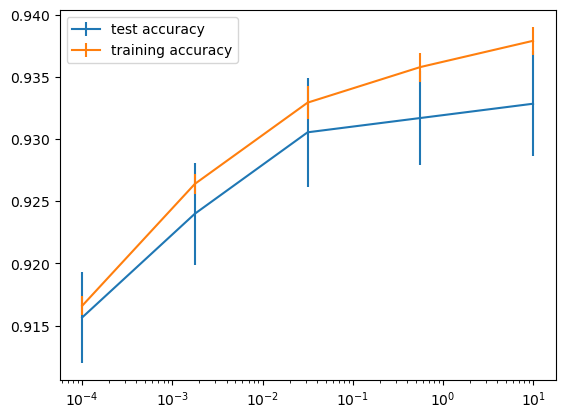

In [7]:
result = gs.cv_results_
plt.errorbar(penalty_param, result["mean_test_score"],
             yerr=result["std_test_score"],
             label = "test accuracy")
plt.errorbar(penalty_param, result["mean_train_score"],
             yerr=result["std_train_score"],
             label = "training accuracy")
plt.xscale("log")
plt.legend()

In [8]:
C = penalty_param[np.argmax(result["mean_test_score"])]
clf = pipeline.make_pipeline(prep.StandardScaler(),
                                 svm.LinearSVC(random_state=random_state,
                                               max_iter=10000,
                                               loss=loss,C=C ))

clf.fit(X,Y);

The pipeline we constructed has two functions, "predict", and "decision function", which allow us to classify the structure of a particle.

``predict()`` returns 0 or 1, predicting that a particle is either non-rearranging or rearranging.

``decision_function()`` is the signed distance to the classifying hyperplane.

The pipeline object automatically combines the appropriate function from the SVM class with the data-scaling function ``transform()`` from the ``StandardScaler`` class.

You can access the scaler as ``clf[0]`` and the SVM as ``clf[1]``. In addition to the functions ``transform()``, ``decision_function()``, and ``predict()``, we can directly access the scalar variables ``mean_`` and ``scale_``, and access the SVM weights ``coef_`` and ``intercept_``.

Let's quickly check that this does what we think:

In [9]:
full_output = clf.decision_function(X)
two_step_output = clf[1].decision_function(clf[0].transform(X))

manual_scaled_X = (X - clf[0].mean_) / clf[0].scale_
manual_dot_product = np.dot(manual_scaled_X, clf[1].coef_[0]) + clf[1].intercept_


print("Pipeline output", full_output)
print("Manual composition", two_step_output)
print("Manual dot product", manual_dot_product)

Pipeline output [ 2.09660147  2.02043972  1.32813431 ... -2.14082874 -0.1821416
 -1.66397388]
Manual composition [ 2.09660147  2.02043972  1.32813431 ... -2.14082874 -0.1821416
 -1.66397388]
Manual dot product [ 2.09660172  2.02043965  1.32813451 ... -2.14082911 -0.18214311
 -1.66397265]


In [10]:
"""
In this cell, check that the classifictation from predict()
matches the sign of decision_function()
"""
print(np.all((1+np.sign(clf.decision_function(X)))/2 == clf.predict(X)))

True


Now we're in a position to start confirming the results of https://doi.org/10.1038/nphys3644.

Because we've made different choices about regularization / loss function than they did, there's no guarantee that our $S$ and theirs won't disagree by a constant factor or shift. However, we expect to reproduce all of their results, otherwise.

All of the main-text results come from computing $S$ on random samples of particles from the whole system, at various temperatures $T$, or from computing $S$ for rearranging particles at some lower rearranging $p_{\mathrm{hop}}$ threshold $p_c = 0.2$.


So first, let's load some more computed structure functions from MD simulations I ran at various temperatures.

Below I've provided code to load both of these sets (structure functions of random particles, and structure functions of random rearranging particles) at a given $T$.

In [11]:
valid_T = ["0.700", "0.600", "0.550","0.500","0.470", "0.420"]

def load_random_structure(T):
  assert T in valid_T
  fn = data_dir+"random_test_desc_"+T+".pkl"
  with open(fn, "rb") as f:
    X = pickle.load(f)

  return X

def load_rearranging_structure(T):
  assert T in valid_T
  fn = data_dir+"rearranging_test_desc_"+T+".pkl"
  with open(fn, "rb") as f:
    X = pickle.load(f)

  return X

Let's start by reproducing Fig. 1 in the paper. We want to plot the distribution of $S$ for rearranging particles and for random particles at $T=0.470$ (our training temperature).

We will need to make frequent use of the distributions. So let's write functions ``compute_PS(T)`` and ``compute_PSR(T)`` which return approximations of these distributions as histograms

I've started these functions below. Finish them, and then plot the distributions as in Fig. 1 of the paper!

The paper claims that $90\%$ of rearranging particles have $S>0$ at the training temperature. See if you can confirm that as well.

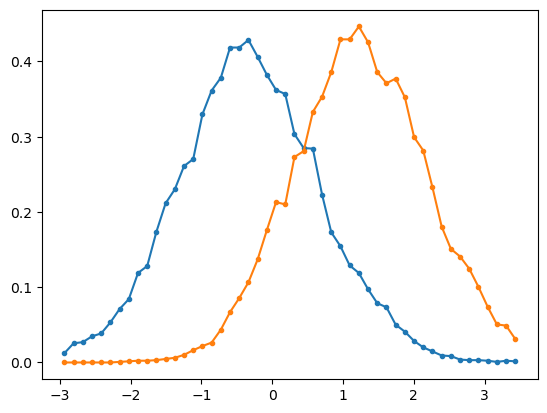

In [12]:
def compute_PS(T, min_S=-3, max_S=3, n_bins=100):
  X = load_random_structure(T)
  S = clf.decision_function(X)
  hist, edges = np.histogram(S, bins=n_bins,
                             range=(min_S, max_S),
                             density=True)

  midpoints = (edges[1:] + edges[:-1])/2
  return midpoints, hist

def compute_PSR(T, min_S=-3, max_S=3, n_bins=100):
  X = load_rearranging_structure(T)
  S = clf.decision_function(X)
  hist, edges = np.histogram(S, bins=n_bins,
                             range=(min_S, max_S),
                             density=True)

  midpoints = (edges[1:] + edges[:-1])/2
  return midpoints, hist



T = "0.470"
min_S=-3
max_S=3.5
n_bins=50

S, PS = compute_PS(T, min_S=min_S, max_S=max_S, n_bins=n_bins)
plt.plot(S, PS,'.-')
S_R, PSR = compute_PSR(T, min_S=min_S, max_S=max_S, n_bins=n_bins)
plt.plot(S_R, PSR,'.-')



Now let's see if we can reproduce Fig 2a-c, which contain the real interesting physical discoveries of this paper.

These figures are built from an empirical quantity $P(R | S,T)$, the probability that a particle of a given $S$, at a given $T$, is rearranging.

In order to construct this quantity, we will need to use Bayes' rule for conditional probabilities:

$$P(R|S) = \frac{P(S|R) P(R)}{P(S)}.$$


Above we've already calculated histograms for $P(S)$ and $P(S|R)$, which we can use directly here.  You can't calculate $P(R)$ from the code I gave you above, however, because I just gave you samples of rearranging particles: I didn't tell you how many particles were rearranging at each temperature.

Below I give a function that loads $p_{\mathrm{hop}}$ for a random sample of particles. Start by using this to write a function which returns $P(R)$ at a given $T$.

Then, put it all together to write a function which returns $P(R|S)$ at a given $T$.

Use this to reproduce Fig. 2a of the paper.


In [13]:
def load_phop(T):
  with open(data_dir+"phop_"+T+".npy", "rb") as f:
    data = np.load(f)
  return data

def load_PR(T):

  p_c = 0.2
  phop = load_phop(T)
  return len(np.where(phop > p_c)[0]) / len(phop)

def compute_PRS(T, min_S=-3, max_S=3, n_bins=10):

  S, PS= compute_PS(T, min_S=min_S, max_S=max_S, n_bins=n_bins)
  SR, PSR = compute_PSR(T, min_S=min_S, max_S=max_S, n_bins=n_bins)


  assert np.all(S == SR)

  PR = load_PR(T)

  PRS = PSR*PR / PS


  return S, PRS

0.420
0.470
0.600


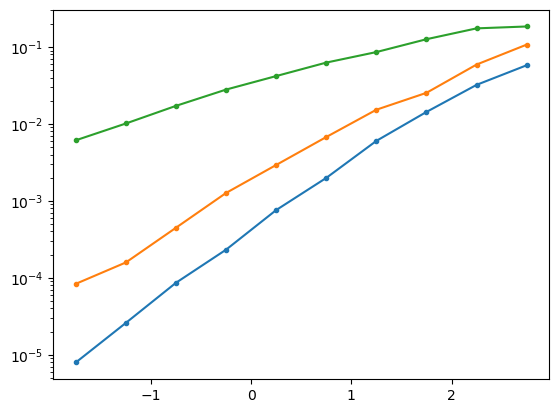

In [14]:
min_S=-2
max_S=3
n_bins=10
for T in ["0.420", "0.470", "0.600"]:
  print(T)
  S, PRS = compute_PRS(T, min_S=min_S, max_S=max_S, n_bins=n_bins)
  plt.semilogy(S, PRS,'.-')

Now let's try to reproduce Fig 2b. To do so, we want to plot $P(R|S,T)$ as a function of $1/T$, for a given $S$ bin.

Let's start by building a big pandas dataframe out of all the $P(R|S, T)$ values. Then we can slice it in the desired way.

In [15]:
min_S = -2
max_S = 3
n_bins = 20


rows = []
for T in valid_T:
  print(T)
  S, PRS = compute_PRS(T, min_S=min_S, max_S=max_S, n_bins=n_bins)
  arg = np.where(np.logical_not(np.isnan(np.log(PRS))))

  midpoints = S #we save this so we have a list of valid S values later

  S = S[arg]
  PRS = PRS[arg]

  for s, prs in zip(S, PRS):
    rows.append({"S":s, "T":T, "P_R":prs})


df = pd.DataFrame(rows)





0.700
0.600
0.550
0.500
0.470
0.420


Now, choose which S bins to plot, and make plots as a function of $1/T$.

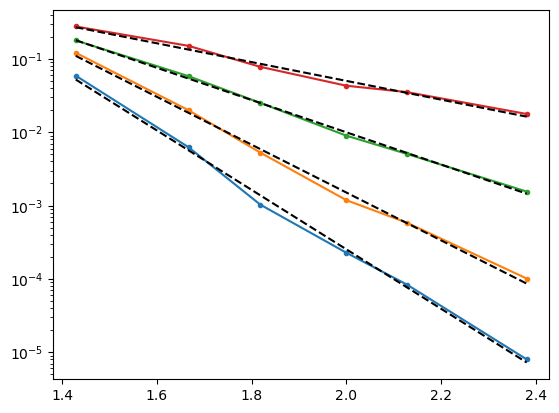

In [16]:

#choose values of S

S_index = np.array([0, 5, 10, 15, ])
S_array = midpoints[S_index]

for S in S_array:
  temp = df[df["S"] == S]
  T = temp["T"].values.astype(float)
  beta = 1.0/T
  P_R = temp["P_R"].values


  plt.semilogy(beta, P_R,'.-')

  degree = 1
  coef = np.polyfit(beta, np.log(P_R), degree)

  sigma = coef[1]
  delta_E = -coef[0]

  plt.semilogy(beta, np.exp(sigma-delta_E*beta),'k--')



Finally, let's reproduce Fig. 2c from the paper. To do this, let's fit a function of the form $$P(R|S,T) = e^{\Sigma(S)-\Delta E(S)/T}$$ to the data, which we can do (not being very statistically rigorous) by a linear fit of $\log{P(R|S)}$ to $1/T$.

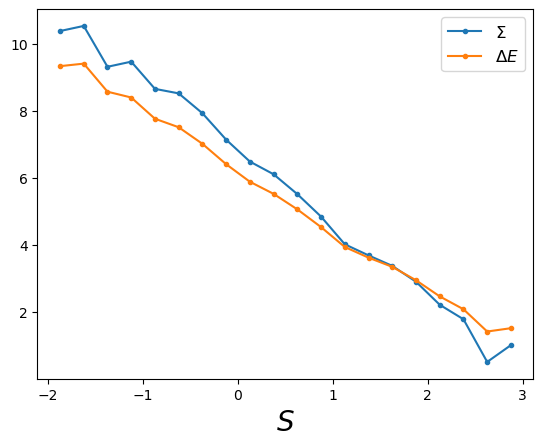

In [17]:
sigma = np.zeros(len(midpoints))
delta_E = np.zeros(len(midpoints))

for i, S in enumerate(midpoints):
  temp = df[df["S"] == S]
  T = temp["T"].values.astype(float)
  beta = 1.0/T
  P_R = temp["P_R"].values

  degree = 1
  coef = np.polyfit(beta, np.log(P_R), degree)

  sigma[i] = coef[1]
  delta_E[i] = -coef[0]



plt.plot(midpoints, sigma,'.-',label=r"$\Sigma$")
plt.plot(midpoints, delta_E,'.-',label=r"$\Delta E$")

plt.legend(fontsize=12)

plt.xlabel(r"$S$", fontsize=20)
plt.show()

We've now reproduced the main physical discovery of softness: different particles behave as if they have something like a "local energy barrier to rearrangement", which can be computed from their local structure!

If you have time, you should check that we actually predict a change in the distribution of energy barriers as $T$ decreases, and that this change is consistent with the "increasing energy barrier with cooling" that we talked about at the beginning!

Then, if we have time left, you should choose one of the following mini-projects and try to do it:

**Study the effect of removing angular structure functions**

Some of the follow-up papers noted that the prediction accuracy on the training set is almost as good if you leave out the angular structure functions (using only the first 200 of the 266 structure functions I gave you), and used this as a justification to not bother with them (because they are way slower to compute).

Honestly, I think this justification is a bit weak: we've already talked about how we don't think the prediction accuracy is terribly meaningful in this problem.

Try removing the 66 angular structure functions, re-training the SVM, and seeing if this has a substantial effect on any of the results. I'm especially curious if the mean and variance of the distribution of predicted energy barriers changes!

**Study the effect of training hyperparameters on the physical predictions**

Pick a different value of $C$ which gave almost the same test accuracy, and see how it changes the predictions.

Does the distribution of $S$ change?

If it does, is this change kind of just like a change of the "units of $S$"? Or is the actual *physical prediction* (e.g., the distrubution of the predicted $\Delta E$) changed?

You could also try switching to the ``hinge`` loss in the ``LinearSVC`` class, although this may take a long time to train.


